[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Loading the dataset...


Repo card metadata block was not found. Setting CardData to empty.



Initial DataFrame Head:
  Symbol                            Security                  Sector  \
0    UTL                  Unitil Corporation               Utilities   
1     HE  Hawaiian Electric Industries, Inc.               Utilities   
2     MG                 Mistras Group, Inc.  Consumer Discretionary   
3    GNK    Genco Shipping & Trading Limited  Consumer Discretionary   
4     BB                  BlackBerry Limited              Technology   

                                  Industry  \
0                         Power Generation   
1              Electric Utilities: Central   
2            Military/Government/Technical   
3                    Marine Transportation   
4  Computer Software: Prepackaged Software   

                                                 URL                 Date  \
0  https://www.nasdaq.com/articles/safest-high-yi...  2009-10-09 11:48:00   
1  https://www.nasdaq.com/articles/safest-high-yi...  2009-10-09 11:48:00   
2  https://www.nasdaq.com/articles

100%|██████████| 441128/441128 [18:32<00:00, 396.47it/s]



All required columns are present.

Training Set Size: (291008, 49)
Testing Set Size: (62358, 49)

Starting Grid Search on subset...
Fitting 3 folds for each of 32 candidates, totalling 96 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Grid Search completed.

Best Parameters from Grid Search:
{'regressor__colsample_bytree': 1.0, 'regressor__learning_rate': 0.05, 'regressor__max_depth': 6, 'regressor__n_estimators': 100, 'regressor__subsample': 0.8}

Retraining the pipeline on the entire training set with best parameters...
Retraining completed.

Making predictions on the test set with the final model...
Predictions completed.

Final Model Performance on Returns:
Mean Squared Error (MSE): 0.4554
Root Mean Squared Error (RMSE): 0.6748
R-squared (R2 ): 0.4078

Sector-wise Metrics (on Returns):
                    Sector        MSE        R2  Sharpe Ratio
0              Industrials   0.201278  0.336509     -0.080481
1              Health Care   0.491336  0.585409     -0.044737
2   Consumer Discretionary   0.143220  0.434779     -0.083686
3              Real Estate   0.192092  0.265442      0.150434
4                  Finance   0.431200  0.614112      0.009045
5               Technology   0.287903  0.279929     -0.057817


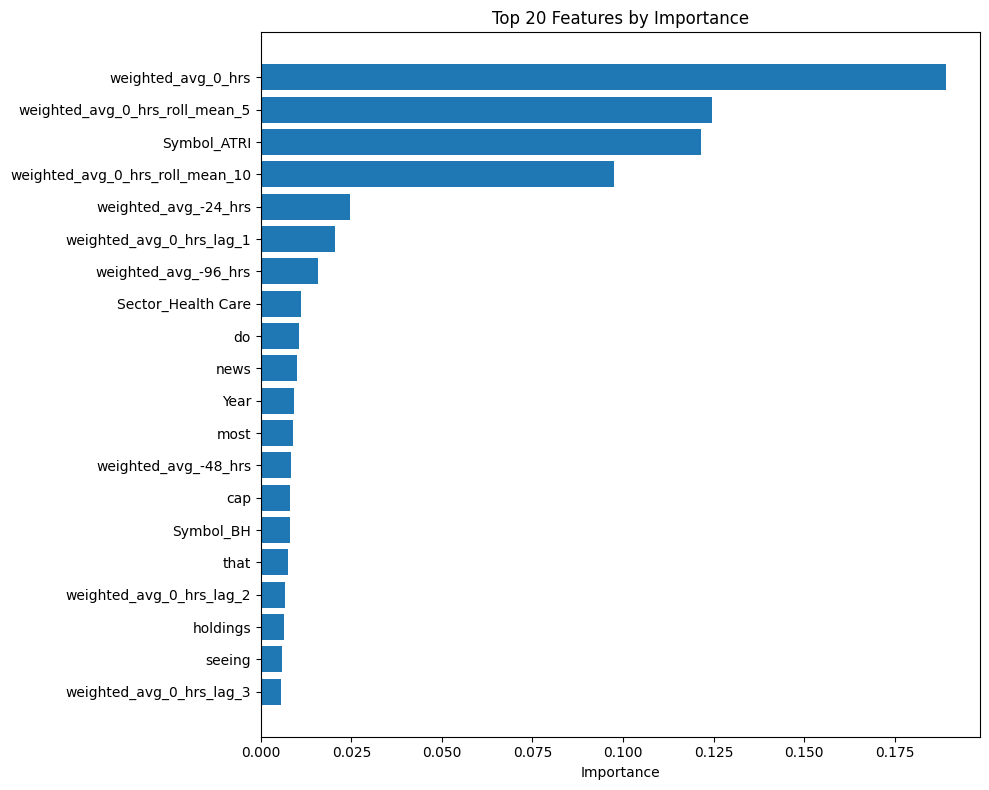


Computing SHAP values for feature interpretability...


100%|===================| 62350/62358 [04:10<00:00]       

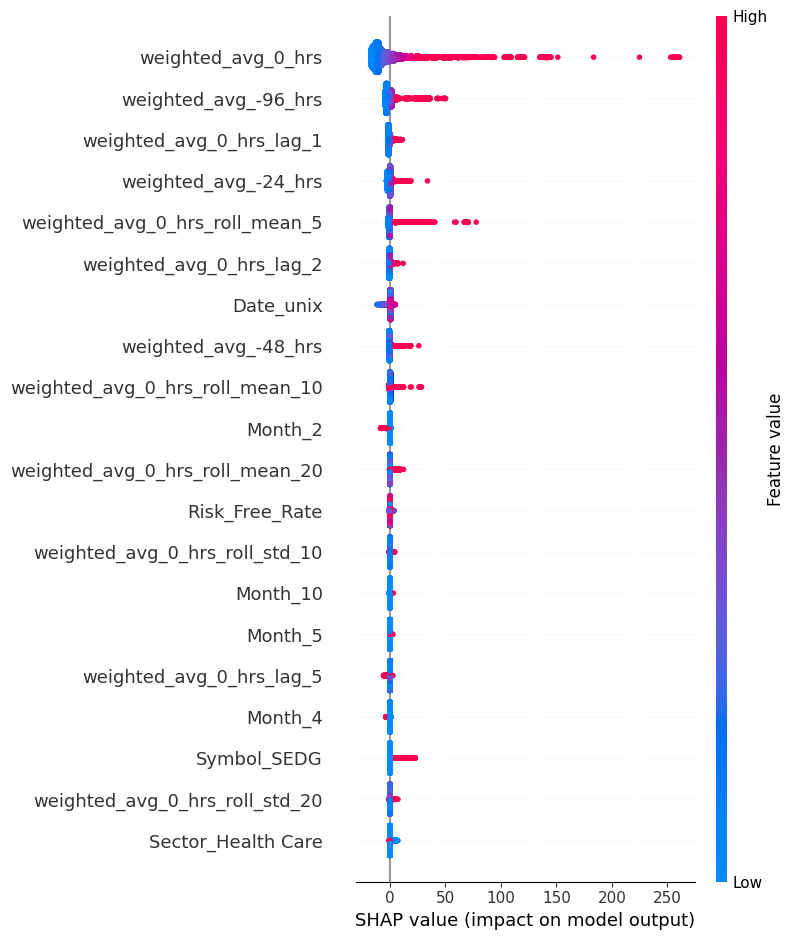


Model saved to xgboost_model_final.joblib


In [2]:
# ---- Install and Import Necessary Libraries ----
!pip install datasets pandas numpy scikit-learn==1.2.2 statsmodels nltk tqdm tensorflow joblib matplotlib category_encoders holidays xgboost shap

import pandas as pd
import numpy as np
from datasets import load_dataset
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import warnings
from tqdm import tqdm
import logging
import nltk
import matplotlib.pyplot as plt
import joblib
from nltk.sentiment import SentimentIntensityAnalyzer
from joblib import Parallel, delayed
from xgboost import XGBRegressor
import shap

# ---- Configure Logging ----
logging.basicConfig(
    level=logging.INFO,
    filename='model_evaluation.log',
    filemode='w',
    format='%(asctime)s - %(levelname)s - %(message)s'
)

# ---- Suppress Warnings ----
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

# ---- Download Necessary NLTK Data ----
nltk.download('vader_lexicon')

# ---- Initialize Sentiment Analyzer ----
sia = SentimentIntensityAnalyzer()

# ---- Function to Compute Sentiment Scores ----
def compute_sentiment(text):
    return sia.polarity_scores(text)['compound']

# ---- Load the Dataset ----
print("Loading the dataset...")
logging.info("Loading the dataset...")
ds = load_dataset("nbettencourt/SC454k")
df = pd.DataFrame(ds['train'])

# Display initial data
print("\nInitial DataFrame Head:")
print(df.head())
print("\nDataFrame Columns:")
print(df.columns)
logging.info(f"Initial DataFrame Head:\n{df.head()}")
logging.info(f"DataFrame Columns:\n{df.columns}")

# ---- Data Preprocessing ----

# 1. Handle Missing Values
df = df.dropna(subset=['weighted_avg_720_hrs', 'weighted_avg_0_hrs'])
df = df[df['weighted_avg_0_hrs'] != 0]

# 2. Parse 'Date' Column
df['Date_cleaned'] = df['Date'].astype(str).str.replace(' ET', '', regex=False)
df['Date'] = pd.to_datetime(df['Date_cleaned'], errors='coerce')
df = df.drop(columns=['Date_cleaned'])

# Drop rows with unparsed dates
df = df.dropna(subset=['Date'])

# 3. Sort by Symbol and Date for per-stock feature engineering
df = df.sort_values(['Symbol', 'Date']).reset_index(drop=True)

# 4. Convert 'Date' to Unix Timestamp
df['Date_unix'] = df['Date'].astype('int64') // 10**9

# 5. Extract Day, Month, Year
df['DayOfWeek'] = df['Date'].dt.dayofweek  # Monday=0, Sunday=6
df['Month'] = df['Date'].dt.month          # January=1, December=12
df['Year'] = df['Date'].dt.year

# Verify new date-related columns
print("\nDataFrame with 'Date_unix', 'DayOfWeek', 'Month', 'Year':")
print(df[['Date', 'Date_unix', 'DayOfWeek', 'Month', 'Year']].head())
logging.info(f"DataFrame with 'Date_unix', 'DayOfWeek', 'Month', 'Year':\n{df[['Date', 'Date_unix', 'DayOfWeek', 'Month', 'Year']].head()}")

# ---- Feature Engineering ----

# Create Lag Features
for lag in [1, 2, 3, 5, 10]:
    df[f'weighted_avg_0_hrs_lag_{lag}'] = df.groupby('Symbol')['weighted_avg_0_hrs'].shift(lag)

# Create Rolling Statistics
for window in [5, 10, 20]:
    df[f'weighted_avg_0_hrs_roll_mean_{window}'] = (
        df.groupby('Symbol')['weighted_avg_0_hrs']
        .rolling(window)
        .mean()
        .reset_index(0, drop=True)
    )
    df[f'weighted_avg_0_hrs_roll_std_{window}'] = (
        df.groupby('Symbol')['weighted_avg_0_hrs']
        .rolling(window)
        .std()
        .reset_index(0, drop=True)
    )

# Create Difference Features
df['weighted_avg_0_hrs_diff_1'] = df.groupby('Symbol')['weighted_avg_0_hrs'].diff(1)

# Apply Sentiment Analysis in Parallel
print("\nComputing sentiment scores for 'Title' and 'Article'...")
logging.info("Computing sentiment scores for 'Title' and 'Article'...")

# Parallel computation for 'Title' Sentiment
df['Title_Sentiment'] = Parallel(n_jobs=-1)(
    delayed(compute_sentiment)(text) for text in tqdm(df['Title'])
)

# Parallel computation for 'Article' Sentiment
df['Article_Sentiment'] = Parallel(n_jobs=-1)(
    delayed(compute_sentiment)(text) for text in tqdm(df['Article'])
)

# Drop rows with any NaN values resulting from feature engineering
df = df.dropna().reset_index(drop=True)

# ---- Feature Selection ----
numeric_features = [
    'weighted_avg_-96_hrs',
    'weighted_avg_-48_hrs',
    'weighted_avg_-24_hrs',
    'weighted_avg_0_hrs',
    'Risk_Free_Rate',
    'Date_unix',
    'Year',
    'weighted_avg_0_hrs_lag_1',
    'weighted_avg_0_hrs_lag_2',
    'weighted_avg_0_hrs_lag_3',
    'weighted_avg_0_hrs_lag_5',
    'weighted_avg_0_hrs_lag_10',
    'weighted_avg_0_hrs_roll_mean_5',
    'weighted_avg_0_hrs_roll_std_5',
    'weighted_avg_0_hrs_roll_mean_10',
    'weighted_avg_0_hrs_roll_std_10',
    'weighted_avg_0_hrs_roll_mean_20',
    'weighted_avg_0_hrs_roll_std_20',
    'weighted_avg_0_hrs_diff_1',
    'Title_Sentiment',
    'Article_Sentiment'
]

categorical_features = ['Symbol', 'Sector', 'Industry', 'Author', 'Publication', 'DayOfWeek', 'Month']
text_features = ['Title', 'Article']
target = 'weighted_avg_720_hrs'

# Check required columns
required_columns = numeric_features + categorical_features + text_features + [target]
missing_cols = set(required_columns) - set(df.columns)
if missing_cols:
    print(f"\nMissing columns in DataFrame: {missing_cols}")
    logging.warning(f"Missing columns in DataFrame: {missing_cols}")
else:
    print("\nAll required columns are present.")
    logging.info("All required columns are present.")

# ---- Train-Test Split ----
# Final sort by Date for chronological train-test split
df = df.sort_values('Date').reset_index(drop=True)

# Calculate sizes
total_length = len(df)
train_size = int(total_length * 0.70)
test_size = int(total_length * 0.15)

# Perform split
train_df = df.iloc[:train_size].reset_index(drop=True)
test_df = df.iloc[train_size:train_size + test_size].reset_index(drop=True)

print(f"\nTraining Set Size: {train_df.shape}")
print(f"Testing Set Size: {test_df.shape}")
logging.info(f"Training Set Size: {train_df.shape}")
logging.info(f"Testing Set Size: {test_df.shape}")

# Define training/testing sets
X_train = train_df[numeric_features + categorical_features + text_features].copy()
y_train = train_df[target].copy()
X_test = test_df[numeric_features + categorical_features + text_features].copy()
y_test = test_df[target].copy()

# ---- Encode Categorical Variables with One-Hot Encoding ----
# Preprocessing for numeric features: No scaling needed for XGBoost

# Preprocessing for categorical features: One-Hot Encoding
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Preprocessing for text features
title_transformer = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(max_features=500))
])

article_transformer = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(max_features=800))
])

# Combine preprocessing for numeric, categorical, and text features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('title_tfidf', title_transformer, 'Title'),
        ('article_tfidf', article_transformer, 'Article')
    ],
    sparse_threshold=0  # dense output for XGBoost
)

# ---- Create the Pipeline with Preprocessing and XGBoost Regressor ----
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        objective='reg:squarederror',
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        random_state=42,
        n_jobs=-1,
        verbosity=1
    ))
])

# ---- Hyperparameter Tuning with Grid Search on a Subset ----
# Subset of 50,000 rows from the training data for Grid Search
subset_size = 50000
if len(X_train) > subset_size:
    X_train_subset = X_train.iloc[:subset_size]
    y_train_subset = y_train.iloc[:subset_size]
    logging.info(f"Selected first {subset_size} rows for Grid Search.")
else:
    X_train_subset = X_train
    y_train_subset = y_train
    logging.info(f"Using entire training set for Grid Search as it contains <= {subset_size} rows.")

# Defining the parameter grid for Grid Search
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [6, 8],
    'regressor__learning_rate': [0.05, 0.1],
    'regressor__subsample': [0.8, 1.0],
    'regressor__colsample_bytree': [0.8, 1.0]
}

# Initialize TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=3)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    verbose=2,
    n_jobs=-1
)

print("\nStarting Grid Search on subset...")
logging.info("Starting Grid Search on subset...")
try:
    grid_search.fit(X_train_subset, y_train_subset)
    print("Grid Search completed.")
    logging.info("Grid Search completed.")
except Exception as e:
    print(f"Grid Search failed with error: {e}")
    logging.error(f"Grid Search failed with error: {e}")
    grid_search = None

if grid_search and grid_search.best_params_:
    print("\nBest Parameters from Grid Search:")
    print(grid_search.best_params_)
    logging.info(f"Best Parameters from Grid Search: {grid_search.best_params_}")

    # ---- Retrain the Pipeline on the Entire Training Set with Best Parameters ----
    pipeline.set_params(**grid_search.best_params_)

    print("\nRetraining the pipeline on the entire training set with best parameters...")
    logging.info("Retraining the pipeline on the entire training set with best parameters...")
    try:
        pipeline.fit(X_train, y_train)
        print("Retraining completed.")
        logging.info("Retraining completed.")
    except Exception as e:
        print(f"Retraining failed with error: {e}")
        logging.error(f"Retraining failed with error: {e}")

    # ---- Make Predictions with the Final Model ----
    print("\nMaking predictions on the test set with the final model...")
    logging.info("Making predictions on the test set with the final model...")
    try:
        y_pred = pipeline.predict(X_test)
        print("Predictions completed.")
        logging.info("Predictions completed.")
    except Exception as e:
        print(f"Predictions failed with error: {e}")
        logging.error(f"Predictions failed with error: {e}")
        y_pred = None

    if y_pred is not None:
        # ---- Compute Additional Metrics ----

        # Calculate Actual and Predicted Returns
        test_df['Actual_Return'] = (test_df['weighted_avg_720_hrs'] / test_df['weighted_avg_0_hrs']) - 1
        test_df['Predicted_Return'] = (y_pred / test_df['weighted_avg_0_hrs']) - 1

        # Remove any remaining NaN or infinite values
        test_df = test_df.replace([np.inf, -np.inf], np.nan).dropna(subset=['Actual_Return', 'Predicted_Return'])

        # ---- Calculate Overall MSE, RMSE, and R2 on Returns ----
        overall_mse_returns = mean_squared_error(test_df['Actual_Return'], test_df['Predicted_Return'])
        overall_rmse_returns = np.sqrt(overall_mse_returns)
        overall_r2_returns = r2_score(test_df['Actual_Return'], test_df['Predicted_Return'])

        print("\nFinal Model Performance on Returns:")
        print(f"Mean Squared Error (MSE): {overall_mse_returns:.4f}")
        print(f"Root Mean Squared Error (RMSE): {overall_rmse_returns:.4f}")
        print(f"R-squared (R2 ): {overall_r2_returns:.4f}")

        logging.info("Final Model Performance on Returns:")
        logging.info(f"Mean Squared Error (MSE): {overall_mse_returns:.4f}")
        logging.info(f"Root Mean Squared Error (RMSE): {overall_rmse_returns:.4f}")
        logging.info(f"R-squared (R2 ): {overall_r2_returns:.4f}")

        # ---- Define Strategy Return ----
        # Strategy: Long position if Predicted_Return > 0, else no position
        test_df['Strategy_Return'] = np.where(test_df['Predicted_Return'] > 0, test_df['Actual_Return'], 0)

        # ---- Sector Metrics (MSE, R2, and Sharpe Ratio per Sector) ----
        sector_metrics = {}

        for sector in test_df['Sector'].unique():
            sector_data = test_df[test_df['Sector'] == sector].copy()
            sector_data = sector_data.dropna(subset=['Actual_Return', 'Predicted_Return'])
            if len(sector_data) == 0:
                sector_metrics[sector] = {'MSE': np.nan, 'R2': np.nan, 'Sharpe Ratio': np.nan}
            else:
                mse_sector = mean_squared_error(sector_data['Actual_Return'], sector_data['Predicted_Return'])
                r2_sector = r2_score(sector_data['Actual_Return'], sector_data['Predicted_Return'])

                # Calculate Sharpe Ratio
                strategy_excess_return = sector_data['Strategy_Return'] - sector_data['Risk_Free_Rate']
                if strategy_excess_return.std() != 0:
                    sharpe_ratio = strategy_excess_return.mean() / strategy_excess_return.std()
                else:
                    sharpe_ratio = np.nan

                sector_metrics[sector] = {'MSE': mse_sector, 'R2': r2_sector, 'Sharpe Ratio': sharpe_ratio}

        # Convert sector metrics to DataFrame
        sector_metrics_df = pd.DataFrame.from_dict(sector_metrics, orient='index').reset_index()
        sector_metrics_df = sector_metrics_df.rename(columns={'index': 'Sector'})

        print("\nSector-wise Metrics (on Returns):")
        print(sector_metrics_df)

        logging.info("Sector-wise Metrics (on Returns):")
        logging.info(f"{sector_metrics_df}")

        # ---- Overall Trend Accuracy ----
        # Calculate the direction of actual and predicted returns
        test_df['Actual_Direction'] = np.where(test_df['Actual_Return'] > 0, 1, 0)
        test_df['Predicted_Direction'] = np.where(test_df['Predicted_Return'] > 0, 1, 0)

        # Calculate accuracy of direction predictions
        overall_trend_acc = (test_df['Actual_Direction'] == test_df['Predicted_Direction']).mean()

        print(f"\nOverall Trend Accuracy: {overall_trend_acc:.2%}")
        logging.info(f"Overall Trend Accuracy: {overall_trend_acc:.2%}")

        # ---- Sharpe Ratio ----
        # Calculate excess returns for the strategy
        test_df['Strategy_Excess_Return'] = test_df['Strategy_Return'] - test_df['Risk_Free_Rate']

        # Calculate Sharpe Ratio
        # Handle case where standard deviation is zero
        if test_df['Strategy_Excess_Return'].std() != 0:
            sharpe_ratio = test_df['Strategy_Excess_Return'].mean() / test_df['Strategy_Excess_Return'].std()
        else:
            sharpe_ratio = np.nan

        print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
        logging.info(f"Sharpe Ratio: {sharpe_ratio:.4f}")

        # ---- Sortino Ratio ----
        # Define target return as 0 for downside deviation
        target_return = 0
        downside_returns = test_df['Strategy_Return'][test_df['Strategy_Return'] < target_return]
        downside_deviation = downside_returns.std()

        # Handle case where downside_deviation is zero
        if downside_deviation != 0:
            sortino_ratio = (test_df['Strategy_Return'].mean() - test_df['Risk_Free_Rate'].mean()) / downside_deviation
        else:
            sortino_ratio = np.nan  # undefined if no downside deviation

        print(f"Sortino Ratio: {sortino_ratio:.4f}")
        logging.info(f"Sortino Ratio: {sortino_ratio:.4f}")

        # ---- Average Return ----
        average_return = test_df['Strategy_Return'].mean()

        print(f"Average Strategy Return: {average_return:.4f}")
        logging.info(f"Average Strategy Return: {average_return:.4f}")

        # ---- Win Rate ----
        # Calculate the proportion of profitable strategy returns
        wins = test_df['Strategy_Return'] > 0
        win_rate = wins.mean()

        print(f"Win Rate: {win_rate:.2%}")
        logging.info(f"Win Rate: {win_rate:.2%}")

        # ---- Profit Factor ----
        # Calculate gross profits and gross losses
        gross_profit = test_df.loc[test_df['Strategy_Return'] > 0, 'Strategy_Return'].sum()
        gross_loss = -test_df.loc[test_df['Strategy_Return'] < 0, 'Strategy_Return'].sum()

        # Handle division by zero
        if gross_loss != 0:
            profit_factor = gross_profit / gross_loss
        else:
            profit_factor = np.inf  # infinite profit factor if no losses

        print(f"Profit Factor: {profit_factor:.4f}")
        logging.info(f"Profit Factor: {profit_factor:.4f}")

        # ---- Print and Log Per-Sector Metrics ----
        print("\nPer-Sector Metrics:")
        logging.info("Per-Sector Metrics:")

        for index, row in sector_metrics_df.iterrows():
            sector = row['Sector']
            mse_sector = row['MSE']
            r2_sector = row['R2']
            sharpe_sector = row['Sharpe Ratio']

            # Print sector metrics
            print(
                f"Sector: {sector} - "
                f"MSE: {mse_sector:.4f}, "
                f"R²: {r2_sector:.4f}, "
                f"Sharpe Ratio: {sharpe_sector:.4f}"
            )

            logging.info(
                f"Sector: {sector} - "
                f"MSE: {mse_sector:.4f}, "
                f"R²: {r2_sector:.4f}, "
                f"Sharpe Ratio: {sharpe_sector:.4f}"
            )

        # ---- Visualize Feature Importance ----
        ohe_features = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
        title_tfidf_features = pipeline.named_steps['preprocessor'].named_transformers_['title_tfidf'].named_steps['tfidf'].get_feature_names_out()
        article_tfidf_features = pipeline.named_steps['preprocessor'].named_transformers_['article_tfidf'].named_steps['tfidf'].get_feature_names_out()

        all_features = list(numeric_features) + list(ohe_features) + list(title_tfidf_features) + list(article_tfidf_features)

        # Get feature importances from XGBoost
        importances = pipeline.named_steps['regressor'].feature_importances_

        # Create a DataFrame for feature importance
        feature_importance_df = pd.DataFrame({
            'Feature': all_features,
            'Importance': importances
        })

        # Sort by importance
        feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

        # Display top 20 features
        top_features = feature_importance_df.head(20)
        print("\nTop 20 Features by Importance:")
        print(top_features)

        # Plot the top 20 features
        plt.figure(figsize=(10, 8))
        plt.barh(top_features['Feature'], top_features['Importance'])
        plt.gca().invert_yaxis()
        plt.xlabel('Importance')
        plt.title('Top 20 Features by Importance')
        plt.tight_layout()
        plt.show()

        # ---- SHAP Feature Importance ----
        print("\nComputing SHAP values for feature interpretability...")
        logging.info("Computing SHAP values for feature interpretability...")

        # Initialize SHAP Explainer
        explainer = shap.Explainer(pipeline.named_steps['regressor'], pipeline.named_steps['preprocessor'].transform(X_train))

        # Compute SHAP values for the test set
        shap_values = explainer(pipeline.named_steps['preprocessor'].transform(X_test))

        # Plot summary plot
        shap.summary_plot(shap_values, pipeline.named_steps['preprocessor'].transform(X_test), feature_names=all_features)

    else:
        print("\nGrid Search was unsuccessful. Skipping further steps.")
        logging.warning("Grid Search was unsuccessful. Skipping further steps.")